In [ ]:
!nvidia-smi

Tue Jul  8 05:50:05 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   45C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import regularizers

In [ ]:
filtered_train_data = pd.read_csv("../data/merged_df.csv")

In [ ]:
filtered_train_data.dropna(inplace = True)
filtered_train_data.drop_duplicates(inplace = True)

In [ ]:
print(filtered_train_data.shape)
filtered_train_data.head()

(31520, 7)


,image_id,x,y,width,height,english_text,hindi_text
0,2341043,324,197,44,22,Silver bracelet around woman's neck.,महिला गर्दन के आसपास सिल्वर ब्रेसेलेट
1,2365053,215,242,243,130,piece of sandwich stuff with lot of meat,सैंडविच का भाग बहुत सारे मांस से भड़ा हुआ
2,2380933,0,0,410,497,a black and white picture of a park scene,एक पार्क दृश्य का काला और सफेद चित्र
3,2402778,19,2,166,209,large rectangular mirror over sink,सिंक पर बड़ा आयताकार दर्पण
4,2396975,216,185,237,82,a car loading food on a plane,हवाई जहाज पर खाना भारित करता हुआ वाहन


In [ ]:
# 1. Add <sos> and <eos> tokens
filtered_train_data['hi'] = filtered_train_data['hindi_text'].apply(lambda x: '<sos> ' + ' '.join(str(x).split()[::-1]) + ' <eos>') # reversing the inut sequence
filtered_train_data['en'] = filtered_train_data['english_text'].apply(lambda x: '<sos> ' + str(x) + ' <eos>')

# 2. Tokenization (word level)
hi_tokenizer = Tokenizer(num_words=50000, filters='', lower=False)
en_tokenizer = Tokenizer(num_words=50000, filters='', lower=False)

hi_tokenizer.fit_on_texts(filtered_train_data['hi'])
en_tokenizer.fit_on_texts(filtered_train_data['en'])

hi_sequences = hi_tokenizer.texts_to_sequences(filtered_train_data['hi'])
en_sequences = en_tokenizer.texts_to_sequences(filtered_train_data['en'])

# 3. Padding
max_hi_len = max(len(seq) for seq in hi_sequences)
max_en_len = max(len(seq) for seq in en_sequences)

hi_padded = pad_sequences(hi_sequences, maxlen=max_hi_len, padding='post')
en_padded = pad_sequences(en_sequences, maxlen=max_en_len, padding='post')

In [ ]:
max_hi_len , max_en_len

(33, 27)

In [ ]:
import pickle

pickle.dump([en_tokenizer,hi_tokenizer,max_en_len,max_hi_len] , open("../models/tokenizers_for_hindi_to_english.pkl", "wb"))

In [ ]:
# Define model parameters
embedding_dim = 256
lstm_units = 256
l2_reg = regularizers.l2(1e-4)  # Weight decay strength

# Vocabulary size (from tokenizers)
vocab_size_hi = len(hi_tokenizer.word_index) + 1  # Hindi vocab
vocab_size_en = len(en_tokenizer.word_index) + 1  # English vocab

# --- Encoder ---
encoder_input = Input(shape=(None,))
encoder_embedding = Embedding(
    input_dim=vocab_size_hi,
    output_dim=embedding_dim,
    mask_zero=True,
    embeddings_regularizer=l2_reg  # Regularization added here
)(encoder_input)
encoder_lstm = LSTM(
    units=lstm_units,
    return_state=True,
    kernel_regularizer=l2_reg,      # Regularization for kernel
    recurrent_regularizer=l2_reg    # Regularization for recurrent connection
)
encoder_output, state_h, state_c = encoder_lstm(encoder_embedding)
encoder_states = [state_h, state_c]

# --- Decoder ---
decoder_input = Input(shape=(None,))
decoder_embedding = Embedding(
    input_dim=vocab_size_en,
    output_dim=embedding_dim,
    mask_zero=True,
    embeddings_regularizer=l2_reg  # Regularization added here
)(decoder_input)
decoder_lstm = LSTM(
    units=lstm_units,
    return_sequences=True,
    return_state=True,
    kernel_regularizer=l2_reg,      # Regularization for kernel
    recurrent_regularizer=l2_reg    # Regularization for recurrent connection
)
decoder_output, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)
decoder_dense = Dense(
    units=vocab_size_en,
    activation='softmax',
    kernel_regularizer=l2_reg  # Regularization added here
)
decoder_output = decoder_dense(decoder_output)

# --- Define the full model ---
model = Model(inputs=[encoder_input, decoder_input], outputs=decoder_output)

In [ ]:
# Model definition
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [ ]:
# Model summary
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 256) │  2,225,152 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, None)      │          0 │ input_layer[0][0] │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 256) │  2,134,784 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ [(None, 256),     │    525,312 │ embedding[0][0],  │
│                     │ (None, 256),      │            │ not_equal[0][0]   │
│                     │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm_1 (LSTM)       │ [(None, None,     │    525,312 │ embedding_1[0][0… │
│                     │ 256), (None,      │            │ lstm[0][1],       │
│                     │ 256), (None,      │            │ lstm[0][2]        │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, None,      │  2,143,123 │ lstm_1[0][0]      │
│                     │ 8339)             │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,553,683 (28.82 MB)

 Trainable params: 7,553,683 (28.82 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
early_stop = EarlyStopping(
    monitor='val_loss',       # Monitor validation loss
    patience=3,               # Stop after 3 epochs without improvement
    restore_best_weights=True,
    verbose = 1
)

In [ ]:
# Shift en_padded to create decoder_target_data (by removing <sos> token or shifting)
decoder_target_data = en_padded[:, 1:]  # Remove first token
decoder_input_data = en_padded[:, :-1]  # Remove last token

# Train the model with EarlyStopping
history = model.fit(
    [hi_padded, decoder_input_data],           # Input: Encoder + Decoder input
    decoder_target_data[..., np.newaxis],      # Output: Decoder targets
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    callbacks=[early_stop]                     # Add callback here
)

Epoch 1/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 29s 30ms/step - accuracy: 0.2828 - loss: 5.0688 - val_accuracy: 0.1181 - val_loss: 3.8641
Epoch 2/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 38s 30ms/step - accuracy: 0.1253 - loss: 3.7431 - val_accuracy: 0.1292 - val_loss: 3.5265
Epoch 3/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 23s 29ms/step - accuracy: 0.1332 - loss: 3.3890 - val_accuracy: 0.1394 - val_loss: 3.2796
Epoch 4/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 26s 33ms/step - accuracy: 0.1433 - loss: 3.1518 - val_accuracy: 0.1453 - val_loss: 3.1357
Epoch 5/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 38s 29ms/step - accuracy: 0.1497 - loss: 2.9576 - val_accuracy: 0.1538 - val_loss: 2.9840
Epoch 6/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 44s 33ms/step - accuracy: 0.1574 - loss: 2.7968 - val_accuracy: 0.1591 - val_loss: 2.9016
Epoch 7/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 39s 30ms/step - accuracy: 0.1636 - loss: 2.6966 - val_accuracy: 0.1628 - val_loss: 2.8381
Epoch 8/100
788/788 ━━━━━━━━━━━━━━━━━━━━ 43s 33ms/step - accuracy: 0.1680 - loss: 2

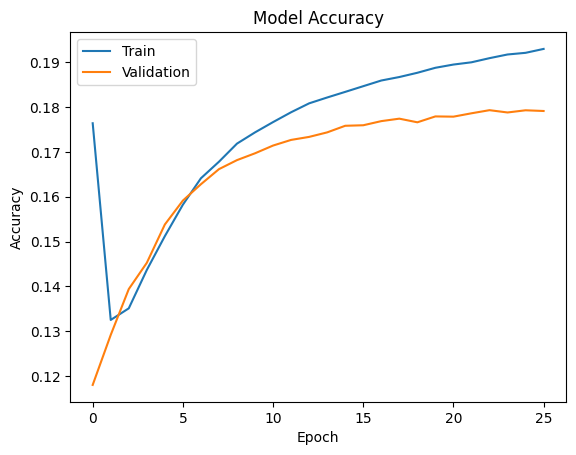

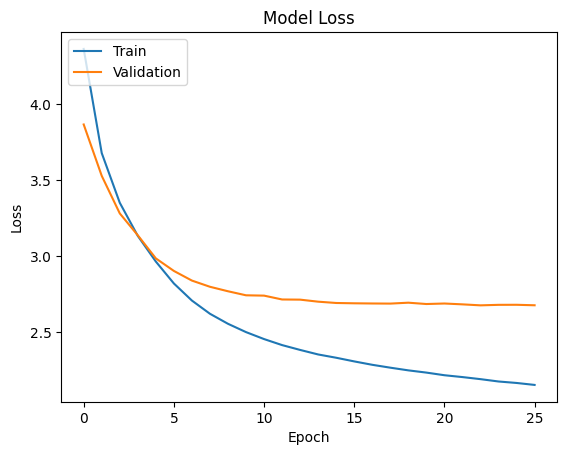

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [ ]:
filtered_train_data.sample(2)

,image_id,x,y,width,height,english_text,hindi_text,hi,en
27597,3553,27,28,278,307,dog is sitting in grass,कुत्ता घास में बैठा है,<sos> है बैठा में घास कुत्ता <eos>,<sos> dog is sitting in grass <eos>
21885,2371025,192,174,237,242,the shirt is white,कुर्ता सफेद है,<sos> है सफेद कुर्ता <eos>,<sos> the shirt is white <eos>


In [ ]:
# hi : हवाई जहाज
# hi : टॉयलेट
# hi : दीवार पर घड़ी
# hi : कुत्ता घास में बैठा है
# hi : महिला का एक ग्रे कोट है

# Inference setup
input_sentence = "<sos> कुत्ता घास में बैठा है <eos>"

# Convert to sequence
input_seq = hi_tokenizer.texts_to_sequences([input_sentence])
input_seq = pad_sequences(input_seq, maxlen=max_hi_len, padding='post')

# Start the decoder input with just <sos>
decoder_input_tokens = [en_tokenizer.word_index['<sos>']]

# Placeholder for output sentence
decoded_sentence = ''

# Predict tokens step-by-step
for _ in range(max_en_len):
    # Prepare decoder input
    decoder_input = np.array(decoder_input_tokens).reshape(1, -1)

    # Predict next token
    output_tokens = model.predict([input_seq, decoder_input], verbose=0)
    predicted_token = np.argmax(output_tokens[0, -1, :])

    # Convert token to word
    predicted_word = en_tokenizer.index_word.get(predicted_token, '')

    if predicted_word == '<eos>':
        break

    decoded_sentence += ' ' + predicted_word

    # Append predicted token to decoder input for next time step
    decoder_input_tokens.append(predicted_token)

# Print final decoded sentence
print(decoded_sentence.strip())

dog sitting in grass


In [ ]:
# right way to save model using keras
model.save("../models/hindi_to_english_model.keras")

In [ ]:
# how to load model

# from tensorflow.keras.models import load_model
# model = load_model("../models/hindi_to_english_model.keras")